In [1]:
import os

from keras import backend as K
from keras import callbacks as ks_cb
from keras import models as ks_mod
from keras import layers as ks_lay
from keras.preprocessing import image as ks_img
from keras import regularizers as ks_reg
from keras import utils as ks_util

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection as sk_ms
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
def read_dataset(path):
    df = pd.read_json(path, lines=True)
    df.dropna(axis=0, how='any', subset=['author', 'text'], inplace=True)
    df.loc[df.comments.isnull(), ['comments']] = df.loc[df.comments.isnull(), 'comments'].apply(lambda x: [])
    df.loc[df.hashtags.isnull(), ['hashtags']] = df.loc[df.hashtags.isnull(), 'hashtags'].apply(lambda x: [])
    return df


In [3]:
#MEME_DIR = '/tmp/memes'
MEME_DIR = '/data/'

def get_downloaded_images(df):
    files = []
    for file in tqdm(df.img_file.values):
        img = os.path.join(MEME_DIR, file)
        if os.path.exists(img):
            files.append(img)
    return files
    
    
def load_images(files):
    imgs = []
    for file in files:
        img = ks_img.load_img(file, target_size=(256, 256))
        img = ks_img.img_to_array(img)
        img = img.astype('float32') / 255.0
        imgs.append(img)
        
    return np.array(imgs)

In [4]:
class ImageLazyLoader(ks_util.Sequence):
    def __init__(self, image_filenames, batch_size):
        self._filenames = image_filenames
        self._batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self._filenames) / float(self._batch_size)))

    def __getitem__(self, idx):
        files = self._filenames[idx * self._batch_size:(idx + 1) * self._batch_size]
        batch_x = load_images(files)
        return batch_x, batch_x

In [5]:
def get_data_generators(data):
    x_train, x_val = sk_ms.train_test_split(data, test_size=0.2)
    x_train_gen = ImageLazyLoader(x_train, 16)
    x_val_gen = ImageLazyLoader(x_val, 16)
    
    return x_train_gen, x_val_gen


In [6]:
def make_encoder(input_dim, embedding_dim, layer_sizes, kernel_size):
    enc_in = ks_lay.Input(shape=input_dim, name='encoder_input')
    x = enc_in
    for ls in layer_sizes:
        x = ks_lay.Conv2D(
            filters=ls,
            kernel_size=kernel_size, 
            strides=2, 
            activation='relu', 
            padding='same'
        )(x)
        
    shape = K.int_shape(x)
    
    x = ks_lay.Flatten()(x)
    embedding = ks_lay.Dense(embedding_dim,
                             activation='sigmoid',
                             name='embedding')(x)
    
    encoder_model = ks_mod.Model(enc_in, embedding, name='encoder')
    return encoder_model, shape


def make_decoder(embedding_dim, enc_conv_shape, layer_sizes, kernel_size):
    dec_in = ks_lay.Input(shape=(embedding_dim,), name='decoder_input')
    
    shape = enc_conv_shape
    x = ks_lay.Dense(shape[1] * shape[2] * shape[3])(dec_in)
    x = ks_lay.Reshape((shape[1], shape[2], shape[3]))(x)
    
    for ls in layer_sizes:
        x = ks_lay.Conv2DTranspose(
            filters=ls,
            kernel_size=kernel_size,
            strides=2,
            activation='relu',
            padding='same'
        )(x)
        
    dec_out = ks_lay.Conv2DTranspose(
        filters=3,
        kernel_size=kernel_size,
        activation='relu',
        padding='same'
    )(x)
    
    decoder_model = ks_mod.Model(dec_in, dec_out, name='decoder')
    return decoder_model


def make_autoencoder(data_dim, embedding_dim, layer_sizes, kernel_size, weights_file=None):
    encoder_model, shape = make_encoder(data_dim, 
                                        embedding_dim, 
                                        layer_sizes, 
                                        kernel_size)

    decoder_model = make_decoder(embedding_dim, 
                                 shape, 
                                 layer_sizes[::-1], 
                                 kernel_size)
    
    ae_in = encoder_model.input
    ae_out =  decoder_model(encoder_model(ae_in))
    autoencoder_model = ks_mod.Model(ae_in, ae_out)
    autoencoder_model.compile(loss='mse', optimizer='adam')
    
    if weights_file:
        autoencoder_model.load_weights(weights_file)
    
    return encoder_model, decoder_model, autoencoder_model


In [7]:
def draw_learning_curves(history_data):
    hist = history_data.history
    
    plt.figure(figsize=(15, 7))
    
    plt.plot(hist['loss'], marker='x', linestyle='--', label='Train')
    plt.plot(hist['val_loss'], marker='x', linestyle='--', label='Validation')
    
    #plt.ylim((0, 1.2 * max(hist['loss'])))
    plt.title('Loss')
    
    plt.legend()
    

In [8]:
def test_model(enc_model, dec_model, files):
    img_orig = load_images(files)
    
    embs = enc_model.predict(img_orig)
    img_pred = dec_model.predict(embs)
    
    fig = plt.figure(figsize=(15, 20))
    axs = fig.subplots(nrows=len(files), ncols=3)
    
    for ax, img_in, emb, img_out in zip(axs, img_orig, embs, img_pred):
        ax[0].imshow(img_in)
        ax[0].set_title('Original')

        ax[1].imshow(np.reshape(emb, (20, 20)), cmap='gray')
        ax[1].set_title('Embedding')
        
        ax[2].imshow(np.clip(img_out, 0, 1))
        ax[2].set_title('Predicted')
        
    fig.tight_layout()


In [9]:
memes = read_dataset('../../data/imgflip_ultra.jl')
#memes.head()

In [10]:
meme_image_files = get_downloaded_images(memes)

In [11]:
len(meme_image_files)

112042

In [12]:
x_train, x_val = get_data_generators(meme_image_files)

In [13]:
encoder, decoder, autoencoder = make_autoencoder(
    data_dim=(256, 256, 3), 
    embedding_dim=400,
    layer_sizes=[16, 16, 8, 8],
    kernel_size=(3, 3),
    weights_file='../../data/ae-100k-9h-weights.h5',
)

In [ ]:
encoder.summary()
decoder.summary()
autoencoder.summary()


In [15]:
cbs = [
    ks_cb.ModelCheckpoint('/project/weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                          monitor='val_loss', 
                          period=4),
    ks_cb.ReduceLROnPlateau(monitor='val_loss',
                            verbose=1, 
                            patience=4, 
                            factor=0.1),
]

history = autoencoder.fit_generator(
    generator=x_train,
    epochs=6,
    validation_data=x_val,
    callbacks=cbs,
)

Epoch 1/6
5603/5603 [==============================] - 1694s 302ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 2/6
5603/5603 [==============================] - 1689s 301ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 3/6
5603/5603 [==============================] - 1692s 302ms/step - loss: 0.0298 - val_loss: 0.0298
Epoch 4/6
5603/5603 [==============================] - 1691s 302ms/step - loss: 0.0298 - val_loss: 0.0298
Epoch 5/6
5603/5603 [==============================] - 1691s 302ms/step - loss: 0.0297 - val_loss: 0.0300
Epoch 6/6
5603/5603 [==============================] - 1697s 303ms/step - loss: 0.0297 - val_loss: 0.0298


In [19]:
autoencoder.save_weights('/project/ae-100k-12h-weights.h5')
autoencoder.save('/project/ae-100k-12h-model.h5')

In [16]:
draw_learning_curves(history)

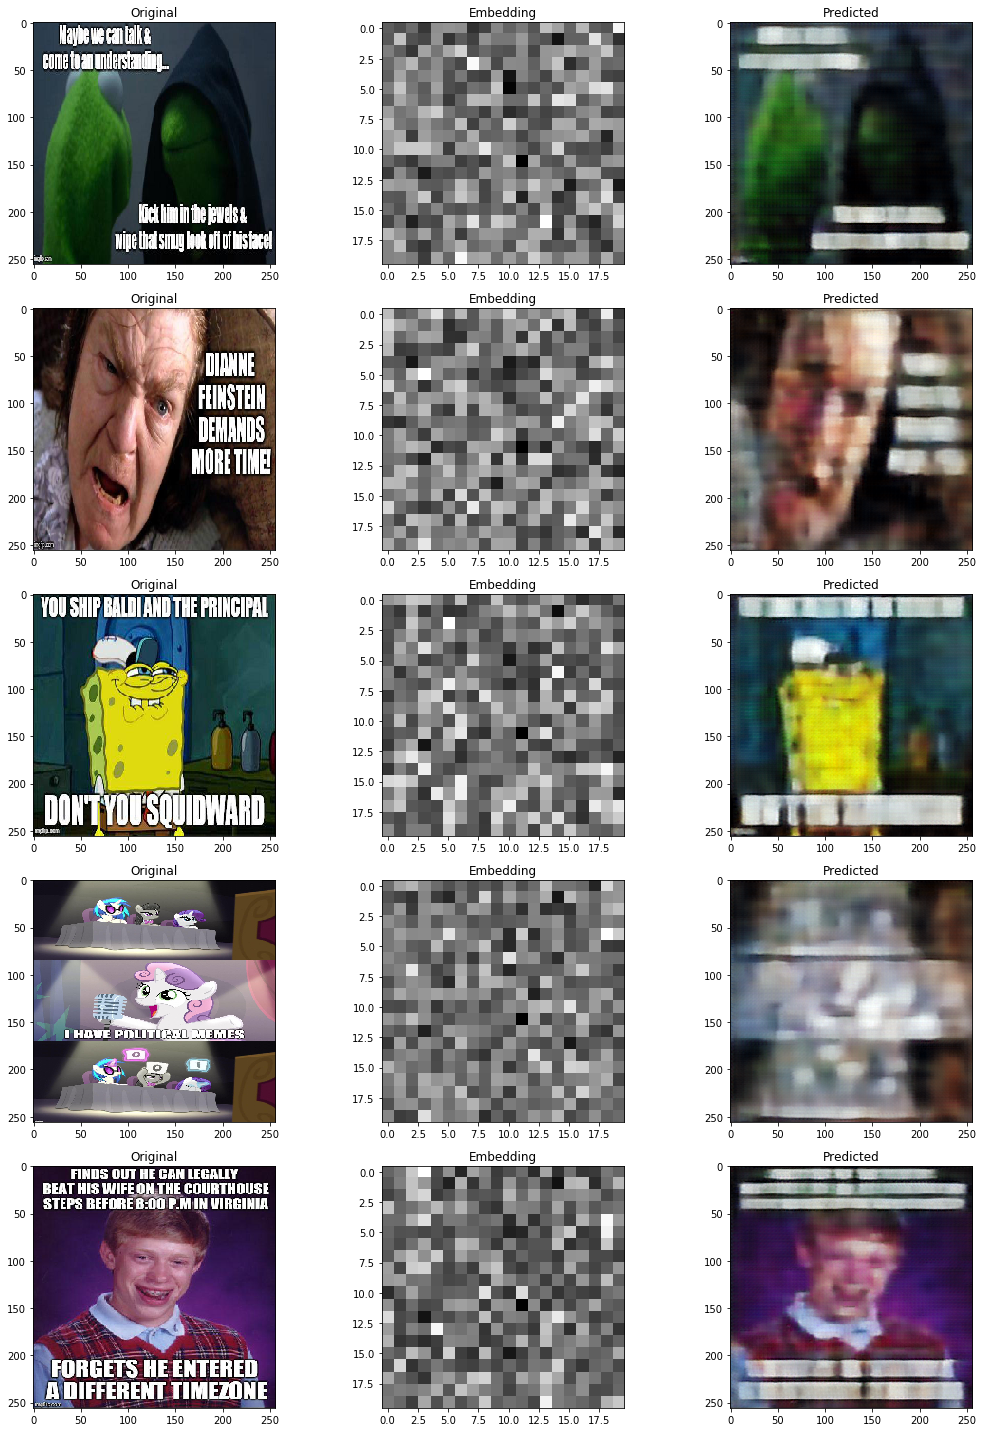

In [18]:
test_model(encoder, decoder, np.random.choice(meme_image_files, 5))
# test_model(encoder, decoder, meme_image_files[20:25])

### Embedding combination

In [ ]:
def f(files):
    # Average embedding of images
    img_orig = load_images(files)
    img_emb = encoder.predict(img_orig)
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('Original images')
    axs = fig.subplots(ncols=len(files))
    if len(files) == 1:
        axs = [axs]
    for ax, img in zip(axs, img_orig):
        ax.imshow(img)
    
    x_emb = np.average(img_emb, axis=0).reshape((1, 400))
    
    # Pure random embedding
    #x_emb = np.random.normal(size=(1, 400))
    
    # Decode embedding to image
    img_pred = decoder.predict(x_emb)
    img_pred = np.clip(img_pred[0], 0, 1)
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('Avg embedding vector + reconstructed image')
    axs = fig.subplots(ncols=2)
    axs[0].imshow(x_emb.reshape(20, 20), cmap='gray')
    axs[1].imshow(img_pred)
    
f(meme_image_files[564:567])

### Similarity check

In [20]:
def get_rows_with_existing_imgs(df):
    df = df.copy()
    df['exists'] = df['img_file'].apply(lambda f: os.path.exists(os.path.join(MEME_DIR, f)))
    df = df[df.exists == True]
    df.drop('exists', axis=1, inplace=True)
    return df


def calc_image_embeddings(df, model):
    img_embs = []
    img_files = [os.path.join(MEME_DIR, f) for f in df.img_file.values]
    
    for img_file in tqdm(img_files):
        img = load_images([img_file])
        img_emb = model.predict(img)
        img_embs.append(img_emb[0])
    
    return np.array(img_embs)


def cosine_distance(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))
    return 1 - cos_sim


def euclidean_distance(a, b):
    return np.linalg.norm(a - b)


def get_most_similar_memes(df, meme_index, distance_fn='cosine', N=5):
    if distance_fn == 'cosine':
        fn = cosine_distance
    elif distance_fn == 'euclidean':
        fn = euclidean_distance
    else:
        raise ValueError('No such distance defined: %s' % distance_fn)
    
    base_img_path = os.path.join(MEME_DIR, df.iloc[meme_index].img_file)
    base_img = load_images([base_img_path])[0]
    base_img_emb = df.iloc[meme_index]['img_emb']
    
    similarities = [(fn(base_img_emb, row['img_emb']),
                     os.path.join(MEME_DIR, row.img_file)) 
                    for idx, row in tqdm(df.iterrows(), total=df.shape[0])
                    if idx != meme_index]
    
    similarities = sorted(similarities, key=lambda x: x[0])[:N]

    fig = plt.figure(figsize=(10, 20))
    axs = fig.subplots(nrows=N + 1)
    
    axs[0].imshow(base_img)
    axs[0].set_title('Base image')
    
    for (s, img_file), ax in zip(similarities, axs[1:]):
        ax.imshow(load_images([img_file])[0])
        ax.set_title('S = %f' % s)
    
    fig.tight_layout()

In [21]:
memes_with_img_emb = get_rows_with_existing_imgs(memes.copy())
memes_with_img_emb['img_emb'] = list(calc_image_embeddings(memes_with_img_emb, encoder))

In [27]:
memes_with_img_emb.to_json('imgflip-with-img-emb.json')

In [25]:
get_most_similar_memes(memes_with_img_emb, 4, 'cosine', N=5)